In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import xarray as xa
from pprint import pprint

fdir = "/home/jungyoung/Project_win/hh_neuralnet/"

import hhclustering as hc
import utils 

from importlib import reload
reload(utils)

from sklearn.cluster import KMeans


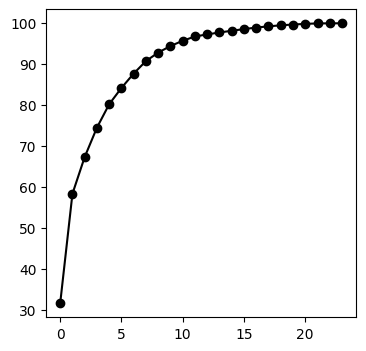

7 90.77645932627057


In [2]:
# load dataset (sub or tot)
with open("./data/align_data_sub.pkl", 'rb') as fp:
    align_data_sub = pkl.load(fp)
    
data = align_data_sub["data"].copy()
echelon = np.array([c["rank"] for c in align_data_sub["col_names"]])

# dimension reduction for visualization
eval, evec, _, cov_mat = hc.pca(data)
pca_proj = np.dot(evec.T, data)

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(eval)/np.sum(eval)* 100, 'ko-')
plt.show()

th = 90
score = np.cumsum(eval)/np.sum(eval)*100
min_id = np.where(score >= th)[0][0]
print(min_id, score[min_id])

def draw_pca_scatter(c=None, s=1, cmap="jet"):
    plt.figure(figsize=(5, 5))
    plt.scatter(pca_proj[0], pca_proj[1], c=c, s=s, edgecolor="none", cmap=cmap)
    plt.show()

In [3]:
# Projection on umap
import umap

N = 2

ufit = umap.UMAP(n_components=N, min_dist=0.2, n_neighbors=20, random_state=1000, n_jobs=1)
umap_proj = ufit.fit_transform(data.T).T

In [84]:
# Load testdataset

from sklearn import cluster, datasets, metrics

def show_pred(data, pred_labels, s=2, **kwargs):
    plt.scatter(data[:, 0], data[:, 1], c=pred_labels, s=s, **kwargs)

# generate test dataset
n_samples = 500
seed = 30

test_dataset = [dict(data=[], labels=[]) for i in range(3)]
test_dataset[0]["data"], test_dataset[0]["labels"] = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
test_dataset[1]["data"], test_dataset[1]["labels"] = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
test_dataset[2]["data"], test_dataset[2]["labels"] = datasets.make_blobs(n_samples=n_samples, random_state=seed)

# K-Means clustering on raw data

## Testdata

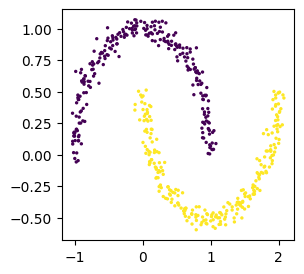

In [89]:
nid = 1
x = test_dataset[nid]["data"].copy()
true_labels = test_dataset[nid]["labels"]

plt.figure(figsize=(3,3))
show_pred(x, true_labels)
plt.show()

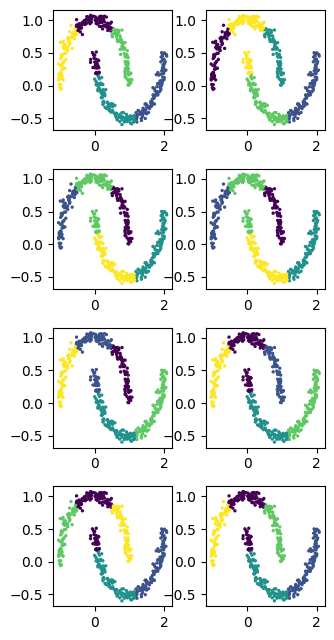

In [105]:
np.random.seed(1000)

plt.figure(figsize=(3.2, 6.5))
for i in range(8):
    
    kobj = KMeans(n_clusters=5, copy_x=True, init="k-means++", n_init=10, random_state=None)
    lb = kobj.fit_predict(x)
    
    plt.subplot(4,2,i+1)
    show_pred(x, lb)
    
plt.tight_layout()
plt.show()
    


# K-Means on UMAP data

## UMAP

In [513]:
import umap

K = 10
N = 2

ufit = umap.UMAP(n_components=N, min_dist=md, n_neighbors=nn, random_state=seed, n_jobs=1)
umap_proj = ufit.fit_transform(data.T).T

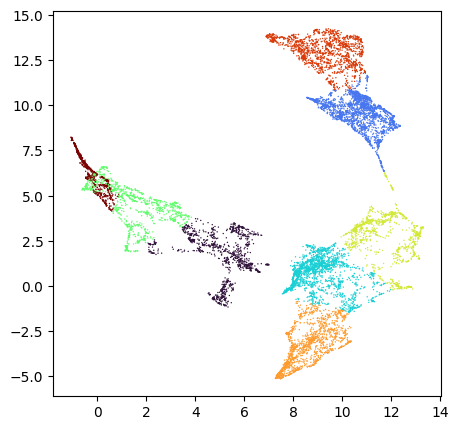

In [514]:
import umap

seed = 500
K = 8
N = 3
md = 0.1
nn = 10

ufit = umap.UMAP(n_components=N, min_dist=md, n_neighbors=nn, random_state=seed, n_jobs=1)
umap_proj = ufit.fit_transform(data.T).T

np.random.seed(seed)
km = KMeans(n_clusters=K, init="k-means++", n_init=1)
id_cluster = km.fit_predict(umap_proj.T)

plt.figure(figsize=(5, 5))
plt.scatter(umap_proj[0], umap_proj[1], s=1, c=id_cluster, edgecolors='none', cmap="turbo")
plt.show()

## UMAP parameter dependency: min_distance

In [526]:
from tqdm.notebook import trange
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [534]:
K = 10
N = 2
nn = 20

nitr = 5
md_set = [0.01, 0.05, 0.1, 0.2, 0.5, 1]

np.random.seed(500)
seed_set = []

mscore = np.zeros([nitr, len(md_set)])

for i in trange(nitr):
    seed = np.random.randint(1000)
    seed_set.append(seed)
    
    idc_target = None
    for j, md in enumerate(md_set):
        ufit = umap.UMAP(n_components=N, min_dist=md, n_neighbors=nn, random_state=seed, n_jobs=1)
        umap_proj = ufit.fit_transform(data.copy().T).T
        
        np.random.seed(seed)
        km = KMeans(n_clusters=K, init="k-means++", n_init=1)
        idc = km.fit_predict(umap_proj.T)
        
        if idc_target is None:
            idc_target = idc.copy()
            
        mscore[i, j] = adjusted_mutual_info_score(idc_target, idc)
        

  0%|          | 0/5 [00:00<?, ?it/s]

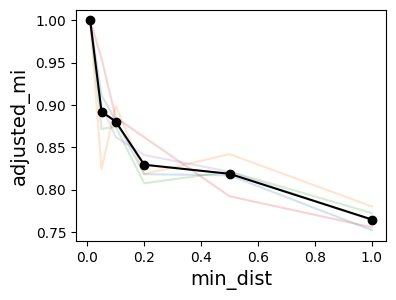

In [551]:
plt.figure(figsize=(4, 3))
plt.plot(md_set, mscore.T, '-', alpha=0.2)
plt.plot(md_set, mscore.mean(axis=0), 'ko-')
plt.xlabel("min_dist", fontsize=14)
plt.ylabel("adjusted_mi", fontsize=14)
plt.show()

In [546]:
K = 10
N = 2
md = 0.2

nitr = 5
nn_set = [5, 10, 50, 100, 500, 1000]

np.random.seed(500)
seed_set = []

mscore_nn = np.zeros([nitr, len(md_set)])

for i in trange(nitr):
    seed = np.random.randint(1000)
    seed_set.append(seed)
    
    idc_target = None
    for j, nn in enumerate(nn_set):
        ufit = umap.UMAP(n_components=N, min_dist=md, n_neighbors=nn, random_state=seed, n_jobs=1)
        umap_proj = ufit.fit_transform(data.copy().T).T
        
        np.random.seed(seed)
        km = KMeans(n_clusters=K, init="k-means++", n_init=1)
        idc = km.fit_predict(umap_proj.T)
        
        if idc_target is None:
            idc_target = idc.copy()
            
        mscore_nn[i, j] = adjusted_mutual_info_score(idc_target, idc)
    

  0%|          | 0/5 [00:00<?, ?it/s]

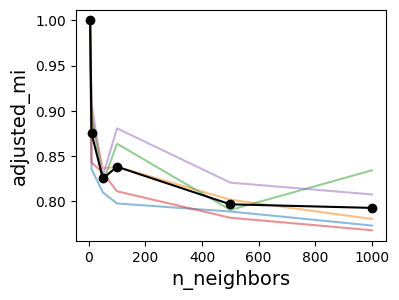

In [552]:
plt.figure(figsize=(4, 3))
plt.plot(nn_set, mscore_nn.T, '-', alpha=0.5)
plt.plot(nn_set, mscore_nn.mean(axis=0), 'ko-')
plt.xlabel("n_neighbors", fontsize=14)
plt.ylabel("adjusted_mi", fontsize=14)
plt.show()

# BIRCH on raw data

In [10]:
from sklearn.cluster import Birch
from sklearn.metrics import adjusted_mutual_info_score
from tqdm.notebook import trange

In [29]:
# np.random.seed(100)
cid_prv = None
K = 10

mb_score = []
for i in trange(10):
    ind = np.arange(data.shape[1])
    np.random.shuffle(ind)

    bobj = Birch(n_clusters=K, compute_labels=True, copy=True)
    bobj.fit(data[:, ind].T)

    cid = bobj.labels_[np.argsort(ind)]
    
    if cid_prv is None:
        cid_prv = cid.copy()
        continue
    
    mb_score.append(adjusted_mutual_info_score(cid_prv, cid))
mb_score = np.array(mb_score)    

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
print(mb_score.mean(), mb_score.std())

0.7281584532332049 0.022695775155226788


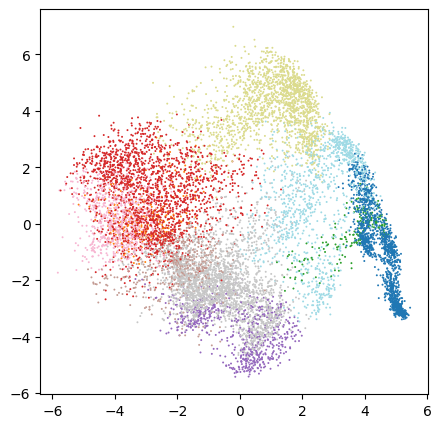

In [33]:
draw_pca_scatter(cid, cmap="tab20_r", s=2)

# K-Means on whitened data

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score
from tqdm.notebook import trange

In [35]:
wdata = np.zeros_like(pca_proj)
for i in range(wdata.shape[0]):
    wdata[i] = pca_proj[i] / np.sqrt(eval[i])
    
erate = np.cumsum(eval) / np.sum(eval) * 100
print(np.where(erate >= 99)[0])

[17 18 19 20 21 22 23]


In [ ]:
def fit_kmeans(data, K, seed):
    kobj = KMeans(n_clusters=K, copy_x=True, init="random", n_init=1, random_state=seed)
    return kobj.fit_predict(data)


def dispense_seed():
    return np.random.randint(10000)


np.random.seed(1000)
K = 15

nitr = 20
naxis = [1, 2, 3, 4, 5, 7, 10, 12, 14, 18, 22, 24]
score = np.zeros([nitr, len(naxis)])

for i in trange(nitr):
    # K-Means clustering on raw data
    cid0 = fit_kmeans(data.T, K, np.random.randint(dispense_seed()))
    
    for j, na in enumerate(naxis):
        # cid = fit_kmeans(wdata[:na+1, :].T, K, np.random.randint(dispense_seed()))
        cid = fit_kmeans(pca_proj[:na+1, :].T, K, np.random.randint(dispense_seed()))
        score[i, j] = adjusted_mutual_info_score(cid0, cid)
    

  0%|          | 0/20 [00:00<?, ?it/s]

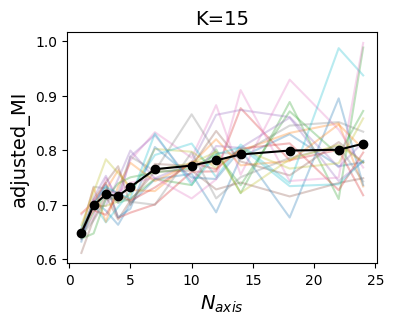

In [149]:
plt.figure(figsize=(4, 3))
plt.plot(naxis, score.T, alpha=0.3)
plt.plot(naxis, score.mean(axis=0), 'ko-')
plt.xlabel(r"$N_{axis}$", fontsize=14)
plt.ylabel("adjusted_MI", fontsize=14)
plt.title("K=%d"%(K), fontsize=14)
plt.show()

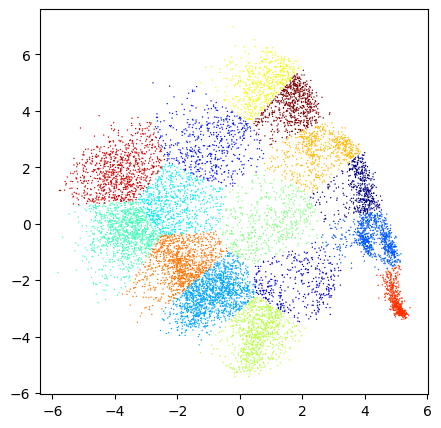

In [ ]:
K = 15

# cid = fit_kmeans(wdata[:2].T, K, dispense_seed())
cid = fit_kmeans(pca_proj[:2].T, K, dispense_seed())
draw_pca_scatter(cid)

# Gaussian mixture model

In [313]:
from tqdm.notebook import trange
from sklearn.mixture import GaussianMixture

## Test

In [384]:
N = 20

np.random.seed(1000)

gmm_best = None
hn_max = 0
for i in trange(5):
    
    seed = np.random.randint(10009)
    gmm = GaussianMixture(
        n_components=N,
        means_init=None,
        tol=1e-9,
        max_iter=2000,
        random_state=seed)
    
    gmm.fit(data.T)
    
    hmax = np.log10(N)
    prob = gmm.predict_proba(data.T)
    hn = (hmax - (-prob * np.log10(prob+1e-9)).mean(axis=1)[0])/hmax
    
    print(f"hn: {hn:4.2f}")
    
    if hn.mean() > hn_max:
        hn_max = hn.mean()
        gmm_best = gmm
    

  0%|          | 0/5 [00:00<?, ?it/s]

hn: 1.00
hn: 1.00
hn: 1.00
hn: 1.00
hn: 1.00


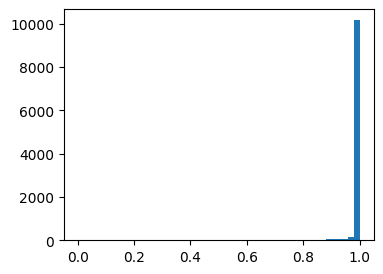

In [413]:
cid = gmm_best.predict(data.T)
prob = gmm_best.predict_proba(data.T)
prob_c = np.array([prob[i, cid[i]] for i in range(prob.shape[0])])

plt.figure(figsize=(4, 3))
plt.hist(prob_c, np.linspace(0, 1, 51))
plt.show()

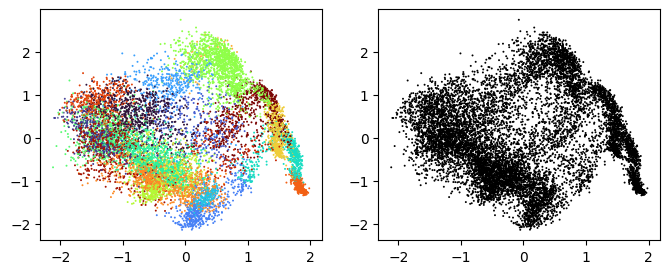

In [414]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(wdata[0], wdata[1], s=2, edgecolor="none", c=cid, alpha=prob_c, cmap="turbo")

plt.subplot(122)
plt.scatter(wdata[0], wdata[1], s=2, edgecolor="none", c="k")

plt.show()

## GMM on PCA projection data

In [528]:
print(erate[10])

N = 20
pca_proj_sub = pca_proj[:10, :]
# pca_proj_sub = pca_proj[:2, :]

gmm = GaussianMixture(
        n_components=N,
        covariance_type="full",
        means_init=None,
        tol=1e-9,
        max_iter=2000,
        random_state=1000)
    
gmm.fit(pca_proj_sub.T)

prob = gmm.predict_proba(pca_proj_sub.T)
hn = (hmax - (-prob * np.log10(prob+1e-9)).mean(axis=1)[0])/hmax

95.72861423772102


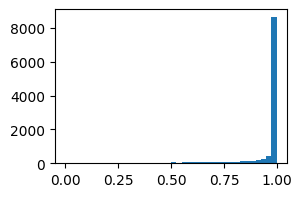

In [529]:
cid = gmm.predict(pca_proj_sub.T)
prob = gmm.predict_proba(pca_proj_sub.T)
prob_c = np.array([prob[i, cid[i]] for i in range(prob.shape[0])])

plt.figure(figsize=(3, 2))
plt.hist(prob_c, np.linspace(0, 1, 41))
plt.show()

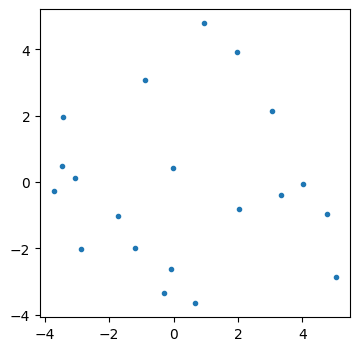

In [530]:
plt.figure(figsize=(4,4))
plt.plot(gmm.means_[:, 0], gmm.means_[:, 1], '.')
plt.show()

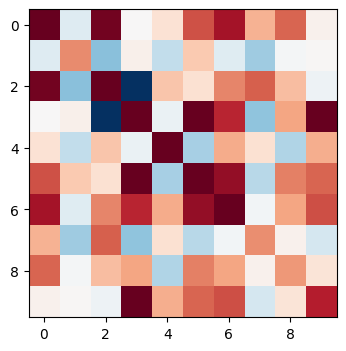

In [531]:
plt.figure(figsize=(4,4))
plt.imshow(gmm.covariances_[15], vmin=-.5, vmax=0.5, cmap="RdBu_r")
plt.show()

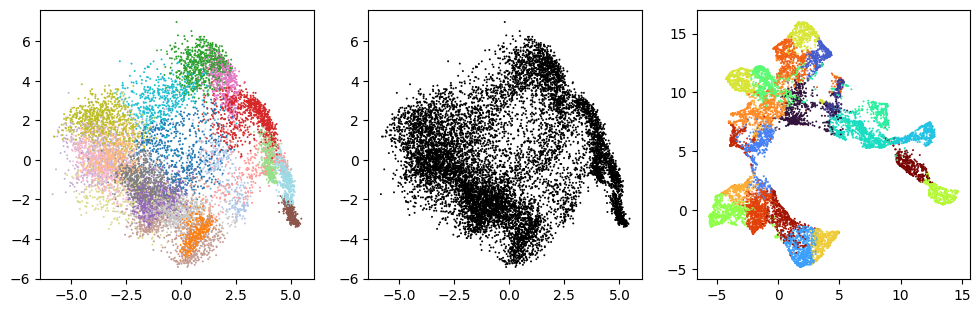

[572, 302, 349, 533, 667, 411, 803, 331, 690, 708, 411, 883, 521, 428, 680, 637, 741, 241, 490, 402]


In [532]:
plt.figure(figsize=(12, 3.5))
plt.subplot(131)
plt.scatter(pca_proj_sub[0], pca_proj_sub[1], s=2, edgecolor="none", c=cid, alpha=prob_c, cmap="tab20")

plt.subplot(132)
plt.scatter(pca_proj_sub[0], pca_proj_sub[1], s=2, edgecolor="none", c="k")

plt.subplot(133)
plt.scatter(umap_proj[0], umap_proj[1], s=2, edgecolor="none", c=cid, alpha=prob_c, cmap="turbo")

plt.show()

print([np.sum(cid == i) for i in range(N)])

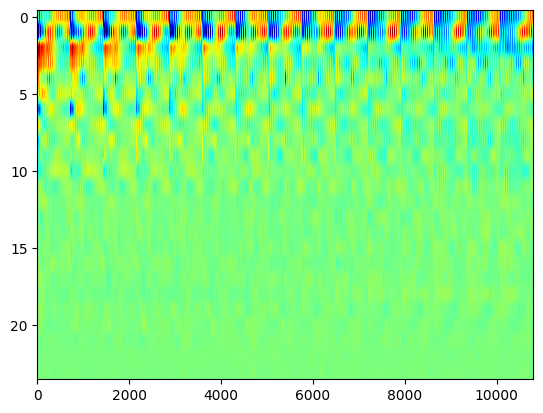

In [533]:
plt.figure()
plt.imshow(pca_proj, aspect="auto", vmin=-3, vmax=3, cmap='jet')
plt.show()

# Evidence Accumulation Clustering (EAC)

In [578]:
from numba import njit

## Test

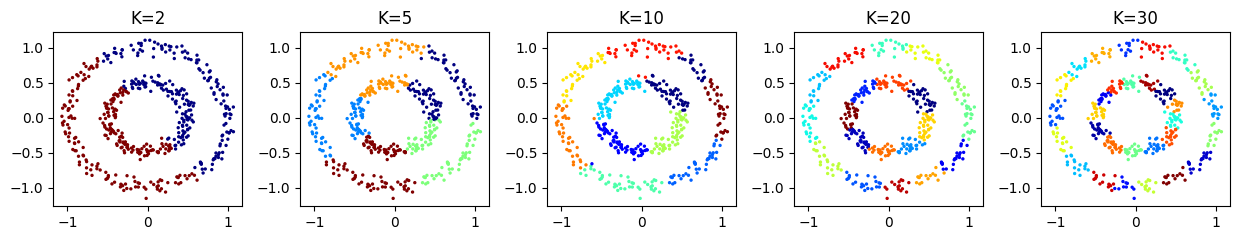

In [106]:
seed = 100
kset = [2, 5, 10, 20, 30]

pred_id_set = []
for k in kset:
    kobj = cluster.KMeans(n_clusters=k, init="k-means++", random_state=seed, copy_x=True, n_init=1)
    pred_id_set.append(kobj.fit_predict(test_dataset[0]["data"]))
    
N = len(kset)
plt.figure(figsize=(2.5*N, 2.5))
for i in range(N):
    plt.subplot(1, N, i+1)
    show_pred(test_dataset[0]["data"], pred_id_set[i], cmap="jet")
    plt.title(f"K={kset[i]}")
plt.tight_layout()
plt.show()

K-means clustering cannot work well when the dataset are on the spherical manifold

In [121]:
@njit
def accumulate_evidence(pred_set):
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    
    cmat = np.zeros((npoint, npoint))
    for i in range(npoint):
        cmat[i, i] = 1
        for j in range(i+1, npoint):
            for n in range(N):
                if pred_set[n, i] == pred_set[n, j]:
                    cmat[i, j] += 1/N
            cmat[j, i] = cmat[i, j]
    return cmat


In [320]:
np.random.seed(10000)

def gen_k():
    # k = 0
    # while k < 2:
    #     k = np.round(np.random.gamma(3, 2)).astype(int)
    
    # k = np.random.randint(98)+2
    k = np.random.randint(2, 90)
    
    return k

x = test_dataset[1]["data"].copy()
pred_id_set = []

kset = []
nitr = 500
for n in range(nitr):
    k = gen_k()
    kobj = cluster.KMeans(n_clusters=k, init="k-means++", random_state=None, copy_x=True, n_init=1)
    pred_id_set.append(kobj.fit_predict(x))
    kset.append(k)
    
cmat = accumulate_evidence(np.array(pred_id_set))
cmat[cmat <= 0] = 0
cmat[cmat >= 1] = 1

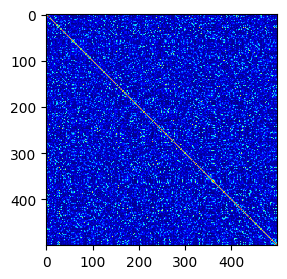

In [321]:
plt.figure(figsize=(3, 3))
plt.imshow(cmat, vmin=0, vmax=0.5, cmap="jet")
plt.show()

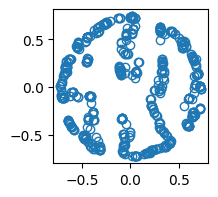

In [322]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, n_jobs=1, dissimilarity="precomputed", random_state=100, normalized_stress=False)
cmat_mds = embedding.fit_transform(1-cmat)

plt.figure(figsize=(2,2))
plt.plot(cmat_mds[:, 0], cmat_mds[:, 1], "o", markerfacecolor="none")
plt.show()

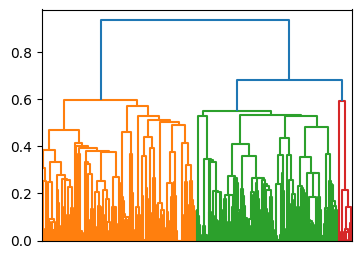

In [323]:
import hhclustering as hc

dmat = 1 - cmat.copy()
model = hc.SLHC(metric="precomputed", method="single")
model.fit(dmat)
cid = model.cut_dend(N=2)

plt.figure(figsize=(4,3))
model.draw_dend()
plt.show()

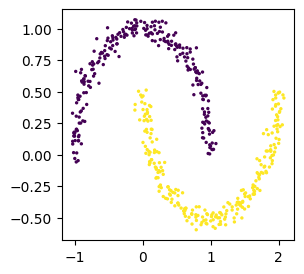

In [324]:
plt.figure(figsize=(3,3))
show_pred(x, cid)
plt.show()

# Weighted Evidence Accumulation Clustering (WEAC)

In [817]:
@njit
def accumulate_evidence(pred_set):
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    
    cmat = np.zeros((npoint, npoint))
    for i in range(npoint):
        cmat[i, i] = 1
        for j in range(i+1, npoint):
            for n in range(N):
                if pred_set[n, i] == pred_set[n, j]:
                    cmat[i, j] += 1/N
            cmat[j, i] = cmat[i, j]
    
    return cmat

## Test

In [6]:
from sklearn import cluster, datasets, metrics

def show_pred(data, pred_labels, s=2, **kwargs):
    plt.scatter(data[:, 0], data[:, 1], c=pred_labels, s=s, **kwargs)

# generate test dataset
n_samples = 500
seed = 30

test_dataset = [dict(data=[], labels=[]) for i in range(3)]
test_dataset[0]["data"], test_dataset[0]["labels"] = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
test_dataset[1]["data"], test_dataset[1]["labels"] = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
test_dataset[2]["data"], test_dataset[2]["labels"] = datasets.make_blobs(n_samples=n_samples, random_state=seed)

In [922]:
from tqdm.notebook import tqdm

kset = np.arange(3, 20)
nitr = 20

pred_id_set = []
np.random.seed(50000)
data = test_dataset[2]["data"].copy()

cmat = np.zeros([n_samples, n_samples])
for k in tqdm(kset):
    for n in range(nitr):
        kobj = cluster.KMeans(n_clusters=k, init="k-means++", random_state=None, copy_x=True, n_init=1)
        pred_id = kobj.fit_predict(data)
        sval = metrics.silhouette_score(data, pred_id)
        
        sval = sval if sval > 0 else 0
        cmat_sub = accumulate_evidence(np.array([pred_id]))        
        cmat += sval * cmat_sub

cmat = cmat / cmat[0, 0]

  0%|          | 0/17 [00:00<?, ?it/s]

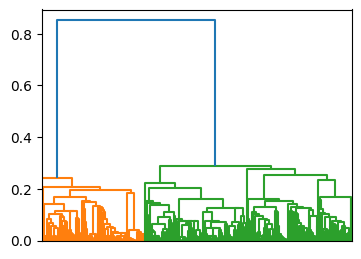

In [923]:
# import hhclustering as hc

dmat = 1 - cmat.copy()
model = hc.SLHC(metric="precomputed", method="single")
model.fit(dmat)

plt.figure(figsize=(4,3))
model.draw_dend()
plt.show()

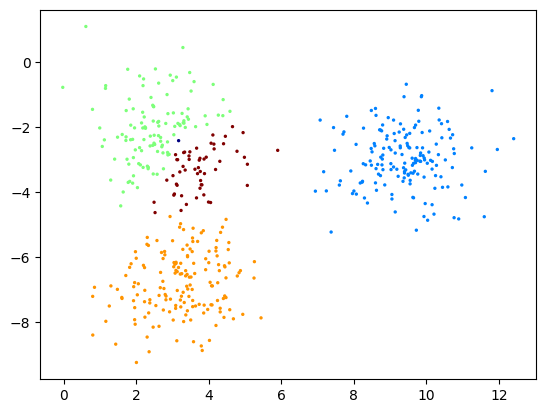

In [929]:
cid = model.cut_dend(N=5)
show_pred(data, cid, cmap="jet")

# Consensus clustering

In [45]:
from numba import njit

@njit
def accumulate_evidence(pred_set):
    npoint = pred_set.shape[1]
    N = pred_set.shape[0]
    
    cmat = np.zeros((npoint, npoint))
    for i in range(npoint):
        cmat[i, i] = 1
        for j in range(i+1, npoint):
            for n in range(N):
                if pred_set[n, i] == pred_set[n, j]:
                    cmat[i, j] += 1/N
            cmat[j, i] = cmat[i, j]
    
    return cmat

## Test

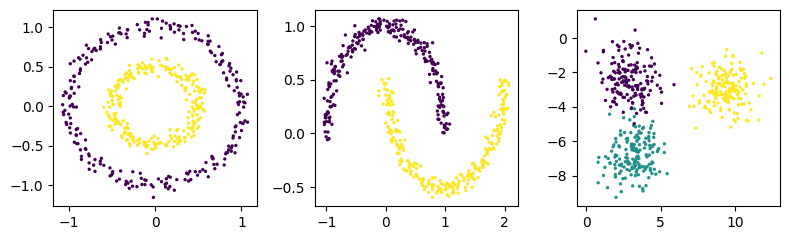

In [4]:
from sklearn import cluster, datasets

def show_pred(data, pred_labels, s=2, **kwargs):
    plt.scatter(data[:, 0], data[:, 1], c=pred_labels, s=s, **kwargs)

# generate test dataset
n_samples = 500
seed = 30

test_dataset = [dict(data=[], labels=[]) for i in range(3)]
test_dataset[0]["data"], test_dataset[0]["labels"] = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
test_dataset[1]["data"], test_dataset[1]["labels"] = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
test_dataset[2]["data"], test_dataset[2]["labels"] = datasets.make_blobs(n_samples=n_samples, random_state=seed)
    


plt.figure(figsize=(8, 2.5))
for i in range(3):
    plt.subplot(1,3,i+1)
    show_pred(test_dataset[i]["data"], test_dataset[i]["labels"])
plt.tight_layout()
plt.show()

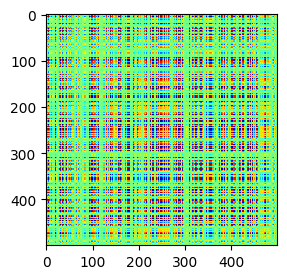

In [805]:
K = 2
nitr = 20

pred_id_set = []
np.random.seed(50000)
for n in range(nitr):
    kobj = cluster.KMeans(n_clusters=K, init="k-means++", random_state=None, copy_x=True, n_init=1)
    pred_id_set.append(kobj.fit_predict(test_dataset[1]["data"]))
    
pred_id_set = np.array(pred_id_set)
cmat = accumulate_evidence(pred_id_set)

plt.figure(figsize=(3,3))
plt.imshow(cmat, cmap="jet", vmin=0, vmax=1)
plt.show()

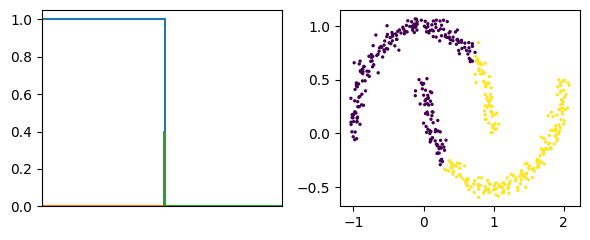

In [814]:
import hhclustering as hc

dmat = 1 - cmat.copy()
dmat[dmat < 0] = 0
model = hc.SLHC(metric="precomputed", method="complete")
model.fit(dmat)
cid = model.cut_dend(N=2)

plt.figure(figsize=(6, 2.5))
plt.subplot(121)
model.draw_dend()

plt.subplot(122)
show_pred(test_dataset[1]["data"], cid)

plt.tight_layout()
plt.show()

# Spectral clustering

## Test

/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


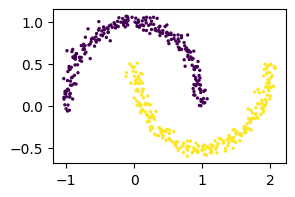

0.3319594705139839


In [38]:
x = test_dataset[1]["data"].copy()

# spec = cluster.SpectralClustering(n_clusters=3, assign_labels="kmeans", n_init=10, 
#                                    affinity="nearest_neighbors", random_state=200)
spec = cluster.SpectralClustering(n_clusters=2, assign_labels="cluster_qr", n_init=10, 
                                    affinity="nearest_neighbors", random_state=100, n_neighbors=10)

labels = spec.fit_predict(x.copy())

plt.figure(figsize=(3,2))
show_pred(x, labels)
plt.show()

print(metrics.silhouette_score(x, labels))

In [43]:
from tqdm.notebook import tqdm

In [79]:
K = 2
x = test_dataset[0]["data"].copy()

pred_labels = []
np.random.seed(5000)
for nitr in tqdm(range(60)):
    cobj = cluster.SpectralClustering(n_clusters=K, assign_labels="cluster_qr", n_init=1, affinity="nearest_neighbors",
                                      n_neighbors=np.random.randint(200)+1, random_state=None)
    pred_labels.append(
    cobj.fit_predict(x.copy())
    )
    
pred_labels = np.array(pred_labels)

  0%|          | 0/60 [00:00<?, ?it/s]

/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warni

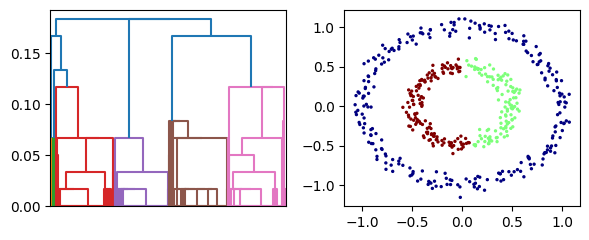

In [80]:
import hhclustering as hc

cmat = accumulate_evidence(pred_labels)

dmat = 1 - cmat.copy()
dmat[dmat < 0] = 0
model = hc.SLHC(metric="precomputed", method="single")
model.fit(dmat)
cid = model.cut_dend(N=2)

plt.figure(figsize=(6, 2.5))
plt.subplot(121)
model.draw_dend()

plt.subplot(122)
show_pred(x, cid, cmap="jet")

plt.tight_layout()
plt.show()

## Consensus clustering mixing K-Means and Spectral clustering

In [1153]:
def dispense_clustering_method(nid, K):
    cobj = None
    if nid == 0:
        cobj = cluster.KMeans(n_clusters=K, n_init=10, random_state=None)
    elif nid == 1:
        cobj = cluster.SpectralClustering(n_clusters=K, assign_labels="kmeans", n_init=10, 
                                          affinity="nearest_neighbors", random_state=None)
    elif nid == 2:
        cobj = cluster.SpectralClustering(n_clusters=K, assign_labels="discretize", n_init=10, 
                                          affinity="rbf", random_state=None)
    else:
        return None
                
    return cobj

In [1169]:
K = 20
x = test_dataset[0]["data"].copy()

pred_labels = []

np.random.seed(5000)
methods = ["nearest_neighbors", "rbf"]
for nitr in tqdm(range(30)):
    cobj = dispense_clustering_method(nitr%3, K)
    pred_labels.append(
        cobj.fit_predict(x.copy())
    )
    
pred_labels = np.array(pred_labels)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warni

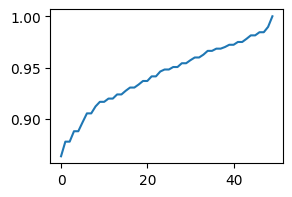

In [1170]:
cmat = accumulate_evidence(pred_labels)
pc, _ = np.histogram(cmat.flatten(), np.linspace(0, 1, 51))
pc = pc / np.sum(pc)

ccum = np.cumsum(pc)

plt.figure(figsize=(3, 2))
plt.plot(ccum)
# plt.ylim([0.5, 1])
plt.show()

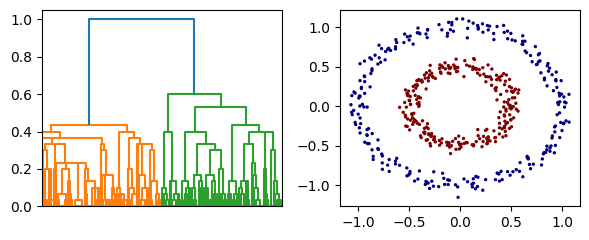

In [1172]:
import hhclustering as hc

cmat = accumulate_evidence(pred_labels)

dmat = 1 - cmat.copy()
dmat[dmat < 0] = 0
model = hc.SLHC(metric="precomputed", method="single")
model.fit(dmat)
cid = model.cut_dend(N=2)

plt.figure(figsize=(6, 2.5))
plt.subplot(121)
model.draw_dend()

plt.subplot(122)
show_pred(x, cid, cmap="jet")

plt.tight_layout()
plt.show()

## Apply on the real dataset

In [4]:
from tqdm.notebook import trange
with open("./data/tmp_pred.pkl", "rb") as fp:
    pred_labels = pkl.load(fp)

In [8]:
kset = np.arange(2, 20)
nitr = 10

N = pred_labels.shape[1]
cmats = np.zeros([len(kset), N, N])

for i in trange(len(kset)):
    cmats[i] = accumulate_evidence(pred_labels[nitr*i:nitr*(i+1)])

  0%|          | 0/18 [00:00<?, ?it/s]

In [19]:
cum_probs = []
for i in range(len(kset)):
    p, _ = np.histogram(cmats[i].flatten(), np.linspace(0, 1, 51))
    cum_probs.append(np.cumsum(p/p.sum()))

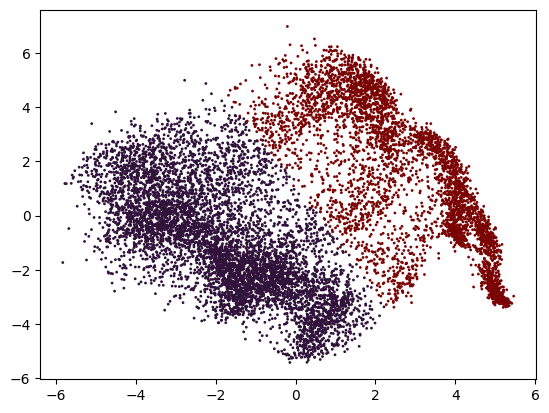

In [111]:
plt.figure()
plt.scatter(pca_proj[0], pca_proj[1], c=pred_labels[0], s=1, cmap="turbo")
plt.show()

In [112]:
align_data_sub["row_labels"]

['$A_{large}(F)$',
 '$\\sigma[A_{large}(F)]$',
 '$A_{large}(S)$',
 '$\\sigma[A_{large}(S)]$',
 '$\\tau_{large}(F)$',
 '$\\sigma[\\tau_{large}(F)]$',
 '$\\tau_{large}(S)$',
 '$\\sigma[\\tau_{large}(S)]$',
 '$A_1(F)$',
 '$\\sigma[A_1(F)]$',
 '$A_1(S)$',
 '$\\sigma[A_1(S)]$',
 '$\\tau_{1}(F)$',
 '$\\sigma[\\tau_{1}(F)]$',
 '$\\tau_{1}(S)$',
 '$\\sigma[\\tau_{1}(S)]$',
 '$C(F)$',
 '$\\sigma[C(F)]$',
 '$\\tau_{cc}(F)$',
 '$\\sigma[\\tau_{cc}(F)]$',
 '$\\eta(F)$',
 '$|\\eta|(F)$',
 '$\\Delta \\phi(F)$',
 '$\\sigma[\\Delta \\phi(F)]$']

In [35]:
from tqdm.notebook import trange
with open("./data/tmp_pred_k.pkl", "rb") as fp:
    result = pkl.load(fp)

pred_labels = result["labels"]

In [45]:
kset = np.arange(2, 20)
nitr = 50

N = pred_labels.shape[1]
cmats = np.zeros([len(kset), N, N])

for i in trange(len(kset)):
    cmats[i] = accumulate_evidence(pred_labels[nitr*i:nitr*(i+1)])

  0%|          | 0/18 [00:00<?, ?it/s]

In [51]:
cum_probs = []
for i in range(len(kset)):
    p, _ = np.histogram(cmats[i].flatten(), np.linspace(0, 1, 51))
    cum_probs.append(np.cumsum(p/p.sum()))

0.1020408163265306 0.8979591836734693


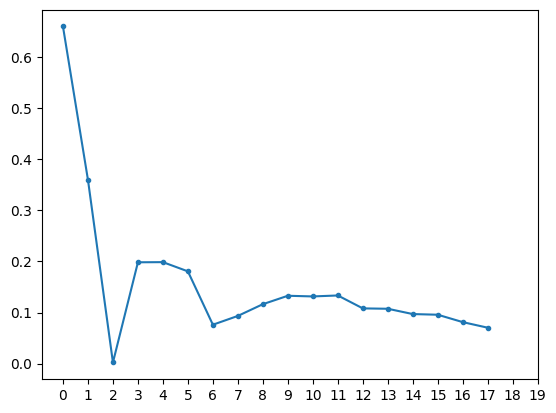

In [63]:
print(x[5], x[-6])

dc = [c[-6] - c[5] for c in cum_probs]

plt.figure()
plt.plot(dc, '.-')
plt.xticks(np.arange(20))
plt.show()

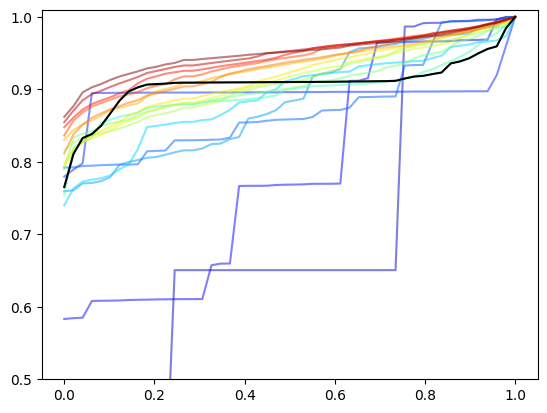

In [101]:
import utils

cmap = utils.get_palette("jet")
x = np.linspace(0, 1, 50)

plt.figure()
for i, c in enumerate(cum_probs):
    plt.plot(x, c, c=cmap((i+1)/len(cum_probs)), alpha=0.5)
plt.plot(x, cum_probs[6], 'k')

plt.ylim([0.5, 1.01])
plt.show()

# plt.plot(np.transpose(cum_probs), c=cmap)

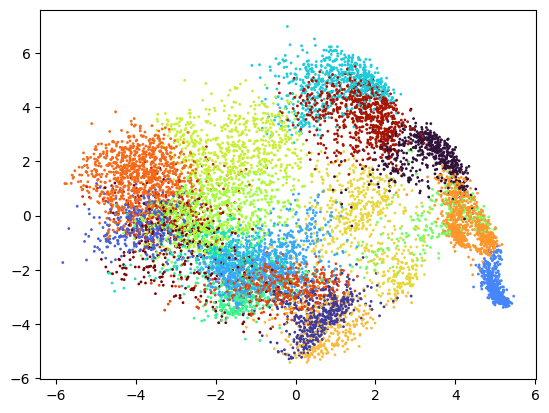

In [113]:
plt.figure()
plt.scatter(pca_proj[0], pca_proj[1], c=pred_labels[890], s=1, cmap="turbo")
plt.show()

In [78]:
dmat = 1 - cmats[6].copy()
dmat[dmat < 0] = 0
dmat[dmat > 1] = 1

model = hc.SLHC(method="single")
model.fit(dmat)

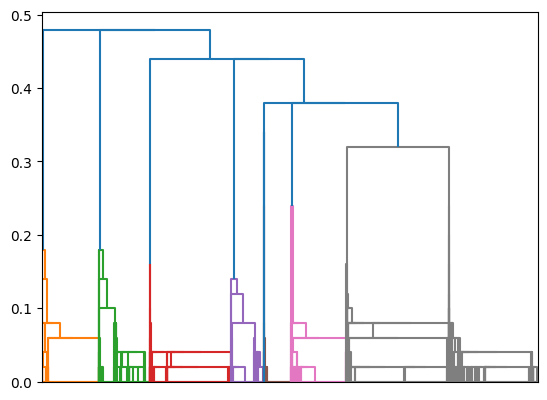

In [79]:
model.draw_dend(no_labels=True)

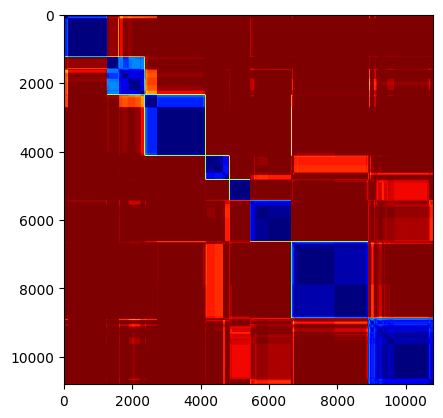

In [86]:
dmat_s, _ = model.sort_dmat(dmat.copy())

plt.figure()
plt.imshow(dmat_s, cmap="jet")
plt.show()

In [114]:
labels = model.cut_dend(N=8)

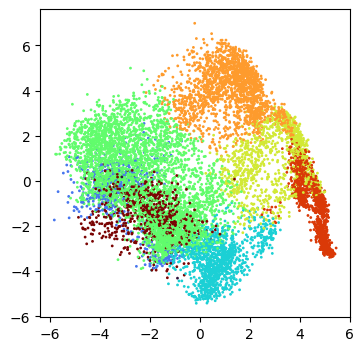

In [120]:
plt.figure(figsize=(4,4))
plt.scatter(pca_proj[0], pca_proj[1], c=labels, s=1, cmap="turbo")
plt.show()

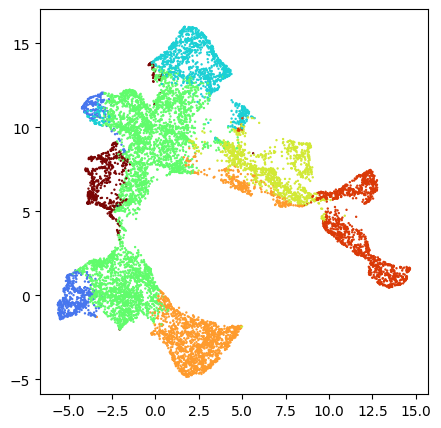

In [119]:
plt.figure(figsize=(5, 5))
plt.scatter(umap_proj[0], umap_proj[1], c=labels, s=0.5, cmap="turbo")
plt.show()

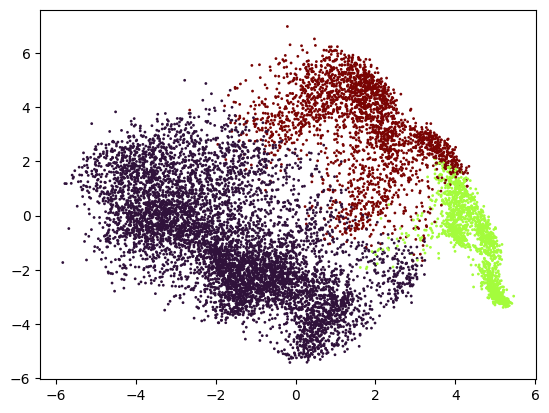

In [1206]:
plt.figure()
plt.scatter(pca_proj[0], pca_proj[1], c=labels, s=1, cmap="turbo")
plt.show()

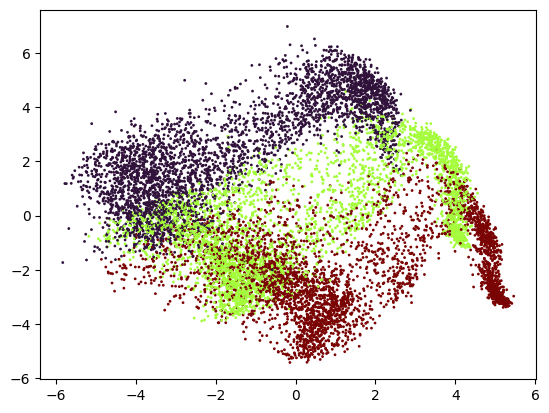

In [1202]:
plt.figure()
plt.scatter(pca_proj[0], pca_proj[1], c=echelon, s=1, cmap="turbo")
plt.show()

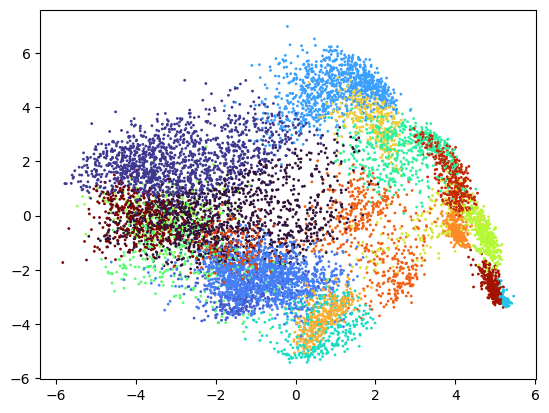

In [1199]:
plt.figure()
plt.scatter(pca_proj[0], pca_proj[1], c=labels, s=1, cmap="turbo")
plt.show()

# Dimension reduction

## PCA


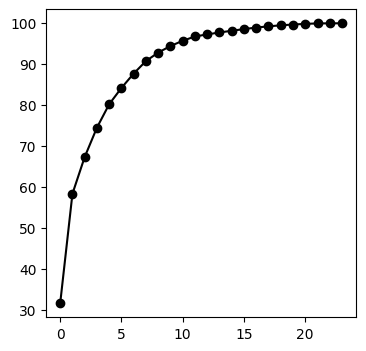

7 90.77645932627057


In [9]:
eval, evec, _, cov_mat = hc.pca(data)
pca_proj = np.dot(evec.T, data)

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(eval)/np.sum(eval)* 100, 'ko-')
plt.show()

th = 90
score = np.cumsum(eval)/np.sum(eval)*100
min_id = np.where(score >= th)[0][0]
print(min_id, score[min_id])

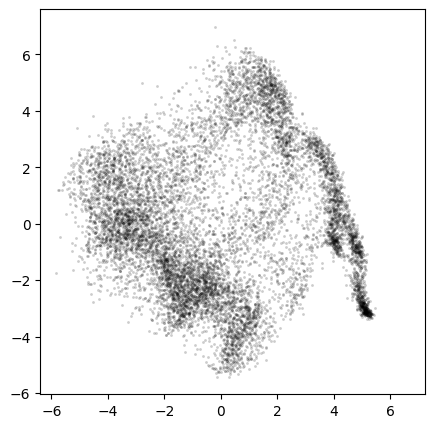

In [10]:
echelon = [c["rank"] for c in align_data_sub["col_names"]]

plt.figure(figsize=(5, 5))
# plt.scatter(proj_data[0], proj_data[1], s=1, edgecolors='none')s
plt.plot(pca_proj[0], pca_proj[1], 'ko', markerfacecolor="none", ms=1, alpha=0.2)
plt.axis("square")
plt.show()

## UMAP

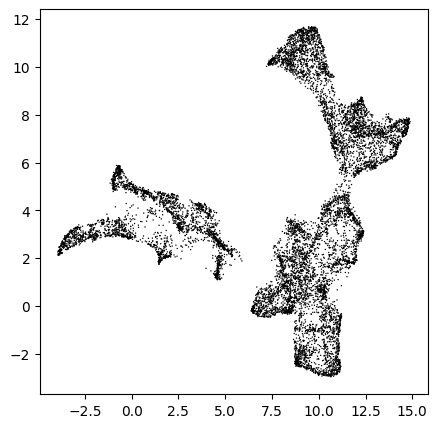

In [313]:
import umap

fit = umap.UMAP(n_components=2, min_dist=0.1, n_neighbors=200)
umap_proj = fit.fit_transform(data.T).T

plt.figure(figsize=(5, 5))
plt.scatter(umap_proj[0], umap_proj[1], s=1, c='k', edgecolors='none')
plt.show()

# Clustering

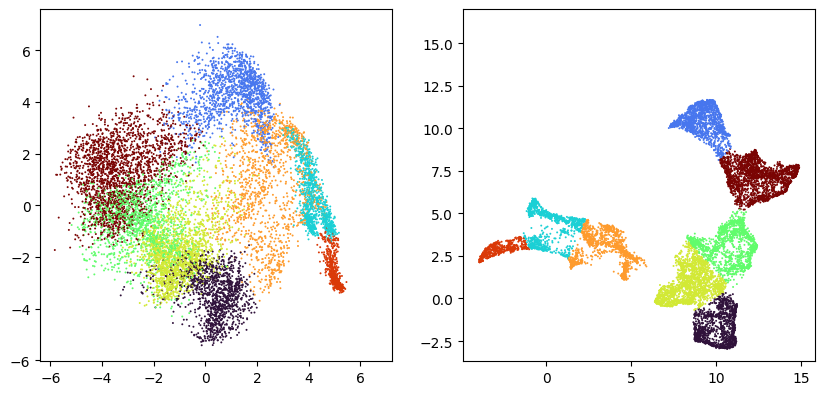

In [496]:
from sklearn.cluster import KMeans

# rdata = pca_proj[:min_id+1, :].copy()
# rdata = pca_proj[:2, :].copy()
# rdata = umap_proj.copy()
# rdata = pca_proj[:min_id+1,:].copy()
# rdata = data.copy()
rdata = umap_proj.copy()

K = 8

# np.random.seed(1000)
km_obj = KMeans(n_clusters=K, init="k-means++", n_init=1)
km_obj.fit(rdata.T)

id_cluster = km_obj.predict(rdata.T)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(pca_proj[0], pca_proj[1], c=id_cluster, s=2, edgecolors='none', cmap="turbo")
plt.axis("square")

plt.subplot(122)
plt.scatter(umap_proj[0], umap_proj[1], c=id_cluster, s=2, edgecolors='none', cmap="turbo")
# plt.plot(rdata[0], rdata[1], 'ko', markerfacecolor="none", ms=1, alpha=0.2)
plt.axis("square")
plt.show()

In [437]:
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

In [459]:
c = fit.graph_.copy()
c = 0.5 * (c + c.T)

In [462]:
ward = cluster.AgglomerativeClustering(n_clusters=15, linkage='ward',
                                       connectivity=c)
ward.fit(umap_proj.T)

AgglomerativeClustering(connectivity=<10800x10800 sparse matrix of type '<class 'numpy.float32'>'
	with 2777390 stored elements in Compressed Sparse Row format>,
                        n_clusters=15)

In [474]:
spectral = cluster.SpectralClustering(n_clusters=15,
                                      eigen_solver='arpack',
                                      affinity="nearest_neighbors")
spectral.fit(umap_proj.T)

/home/jungyoung/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=15)

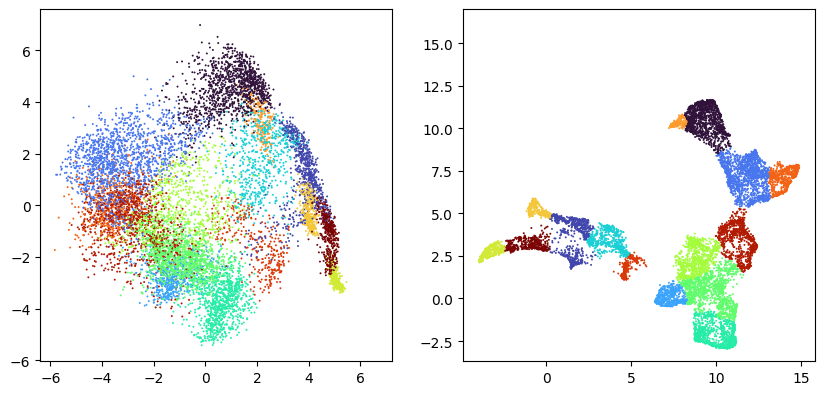

In [475]:
from sklearn.cluster import KMeans


id_cluster = spectral.labels_

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(pca_proj[0], pca_proj[1], c=id_cluster, s=2, edgecolors='none', cmap="turbo")
plt.axis("square")

plt.subplot(122)
plt.scatter(umap_proj[0], umap_proj[1], c=id_cluster, s=2, edgecolors='none', cmap="turbo")
# plt.plot(rdata[0], rdata[1], 'ko', markerfacecolor="none", ms=1, alpha=0.2)
plt.axis("square")
plt.show()

In [449]:
np.unique(ward.labels_)

array([0, 1])

In [448]:
ward.labels_.shape

(10800,)

## hdbscan

In [20]:
import hdbscan

In [428]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True,
                     metric="euclidean")
hdb.fit(umap_proj.T)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=50)

<Axes: >

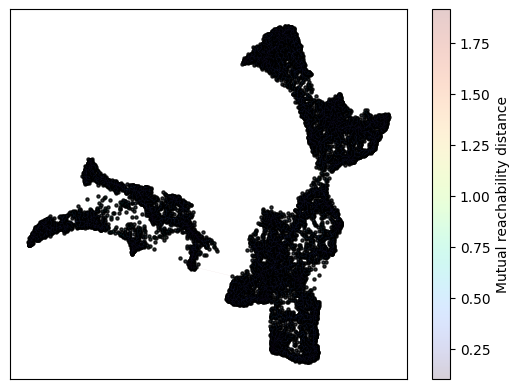

In [429]:
hdb.minimum_spanning_tree_.plot(edge_cmap="turbo", edge_alpha=0.2, node_size=5, edge_linewidth=0.1)

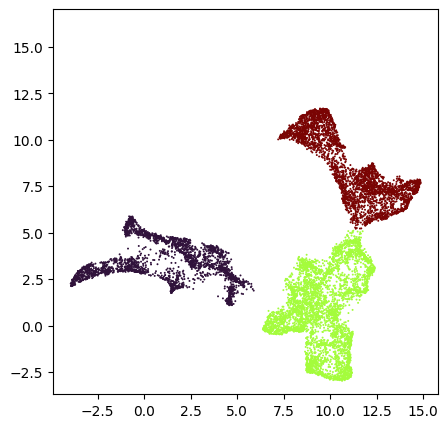

In [430]:
plt.figure(figsize=(5, 5))
# plt.scatter(rdata[0], rdata[1], c=hdb.labels_, s=2, edgecolors='none', cmap="turbo")
plt.scatter(umap_proj[0], umap_proj[1], c=hdb.labels_, s=2, edgecolors='none', cmap="turbo")
# plt.plot(rdata[0], rdata[1], 'ko', markerfacecolor="none", ms=1, alpha=0.2)
plt.axis("square")
plt.show()

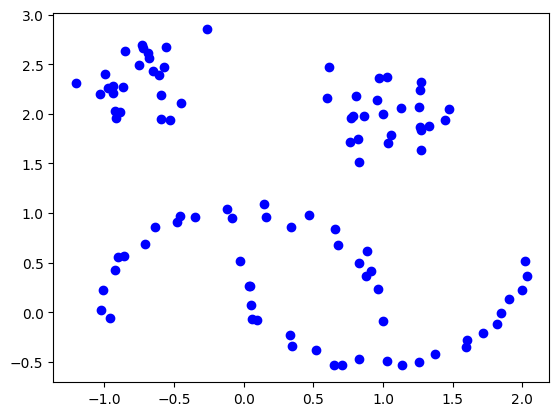

In [65]:
import sklearn.datasets as data

moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b')

In [46]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

<Axes: >

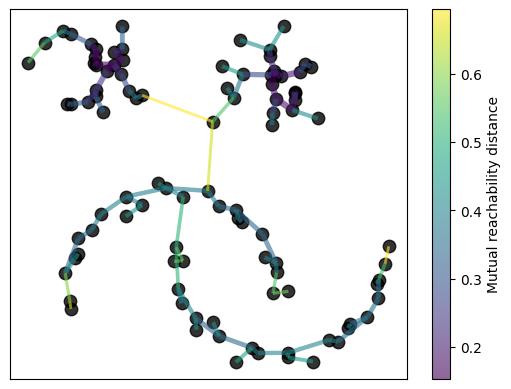

In [47]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<Axes: ylabel='distance'>

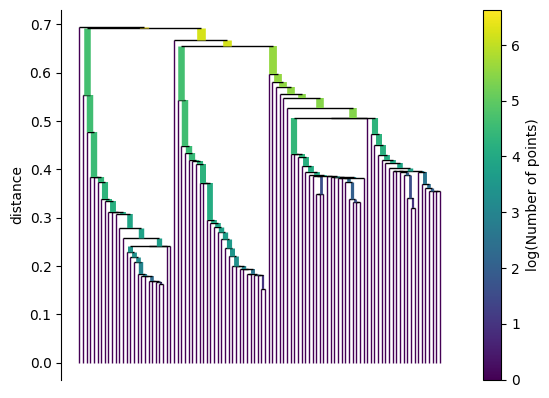

In [48]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)


<Axes: ylabel='$\\lambda$ value'>

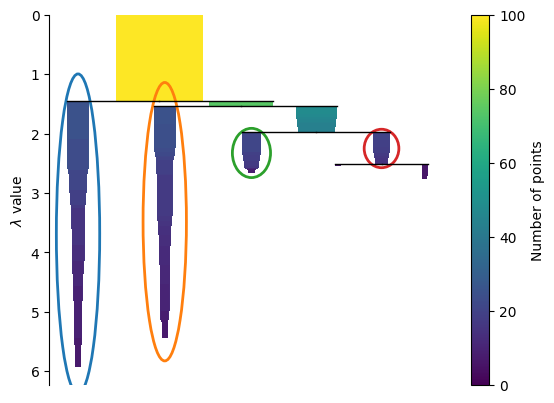

In [50]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


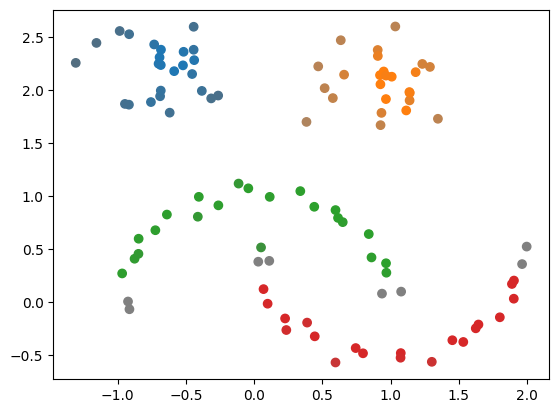

In [52]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors)